In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics

from scipy import stats, signal

In [ ]:
def VTC(filename, key: str = 'RT'):
    """
    This function takes in a filename and a variable name and compute variance time course.

    Kwargs:
        filename:
            Name of the file in xls form.
        key:
            Name of the variable of interest (RT, Dev, MT, etc.) in string form. Defaults to response time (RT).
    """
    
    file = pd.read_excel(filename)

    #Replace values with NA if values are smaller than 0.1
    file[key] = file[key].where(file[key] > 0.1, np.NaN) 

    #Interpolate for NA points
    file[key] = file[key].interpolate(method = 'linear')

    #Find z-score and take absolute values
    file['zRT'] = abs(stats.zscore(file[key]))
    
    #Take 20 points in each computation and compute Gaussian function. We can play around with these parameters
    L = 20
    W = signal.windows.gaussian(L, 2.355)/7 

    #Apply zero phase filtering in each window
    VTC_smooth = signal.filtfilt(W, 1, file['zRT'], padtype = None, padlen= None)

    #Smoothed values lower than median scores are in-zone periods, and higher smoothed values are out-zone periods
    file['smoothed'] = VTC_smooth
    med = statistics.median(file['smoothed'])
    file['zone'] = np.where(file['smoothed'] < med,'in-zone','out-zone')

    return file

### Run file

In [20]:
data = VTC('HarryE1Participant1.xls', 'RT')

### Graph VTC

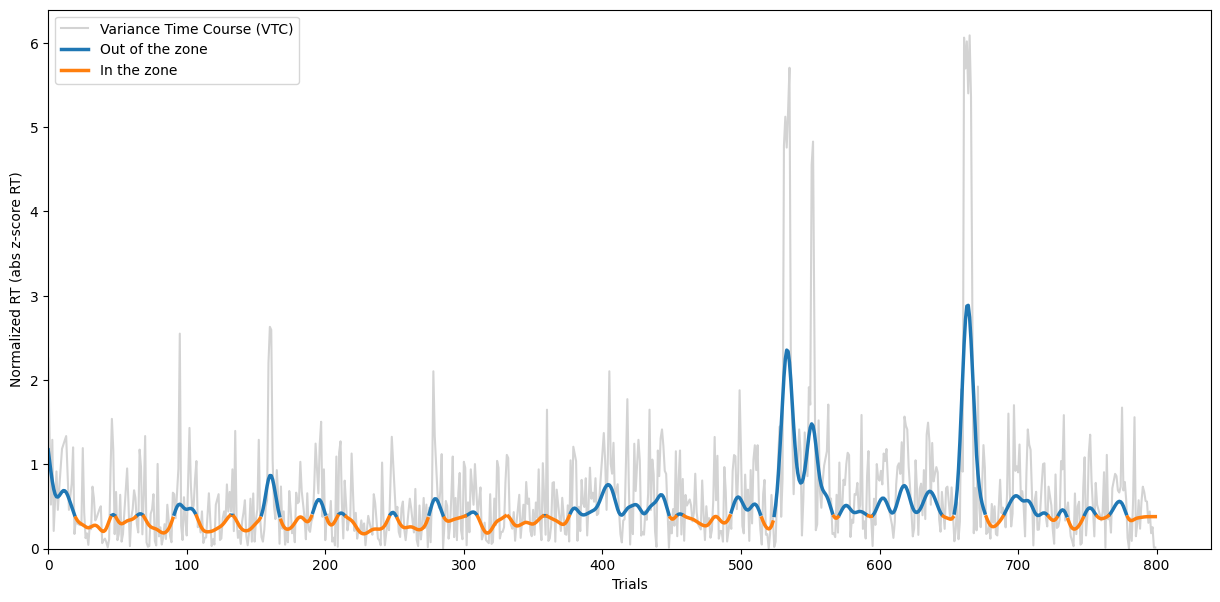

In [21]:
med = statistics.median(data['smoothed'])
in_zone = np.ma.masked_where(data['smoothed'] > med, data['smoothed']) #Discard all the points that bigger than median smoothed values
out_zone = np.ma.masked_where(data['smoothed'] < med, data['smoothed'])


fig, ax = plt.subplots()
ax.plot(data['zRT'], color = 'lightgrey', label = 'Variance Time Course (VTC)')
ax.plot(data['smoothed'].index, out_zone, label = 'Out of the zone ', linewidth = 2.5)
ax.plot(data['smoothed'].index, in_zone, label = 'In the zone ', linewidth = 2.5)
ax.set_ylim(0)
ax.set_xlim(0)

plt.legend(loc = 'best')
#plt.legend(loc= 'upper right', bbox_to_anchor=(0, 0., 0.5, 0.5))
fig.set_figheight(7)
fig.set_figwidth(15)
ax.set_xlabel('Trials')
ax.set_ylabel('Normalized RT (abs z-score RT)')
plt.show()